Fitting 3 folds for each of 24 candidates, totalling 72 fits


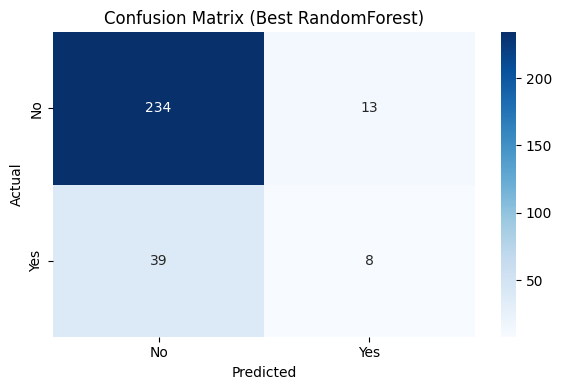

Best Score: 0.43384938195219713
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [26]:
# 파일 다시 불러오기
import pandas as pd

data_path = "/content/processed_datasets.csv"
df = pd.read_csv(data_path)

# 특성과 타겟 분리
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# 학습/테스트 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 하이퍼파라미터 튜닝을 위한 GridSearchCV 구성
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# 모델 학습 및 최적 파라미터 탐색
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# 예측 및 평가
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# confusion matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Best RandomForest)")
plt.tight_layout()
plt.show()


print("Best Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)



In [27]:
# 테스트 세트 예측 10개
import numpy as np
proba = best_model.predict_proba(X_test)[:10]
proba_pct = (proba*100).round(2) # 확률
proba_index = np.argmax(proba_pct, axis=1) # class
print("확률 (%):")
print(proba_pct)
print("\n class index:")
print(proba_index)

확률 (%):
[[27.47 72.53]
 [84.05 15.95]
 [82.03 17.97]
 [95.88  4.12]
 [67.8  32.2 ]
 [75.33 24.67]
 [88.94 11.06]
 [86.82 13.18]
 [93.16  6.84]
 [41.38 58.62]]

 class index:
[1 0 0 0 0 0 0 0 0 1]


Accuracy: 0.8231
F1 Score: 0.2353
AUC Score: 0.7713


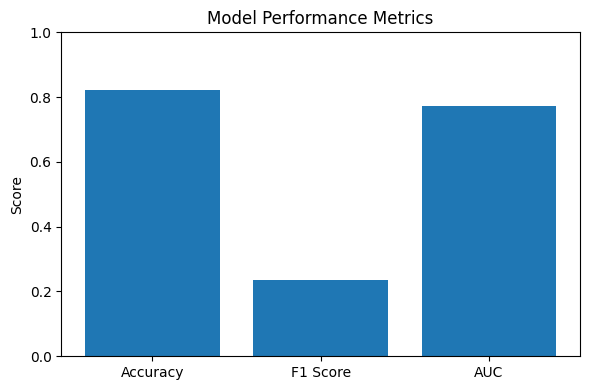

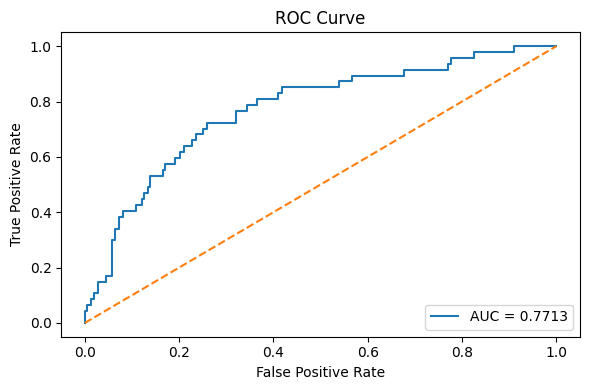

In [28]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 예측
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# 평가 지표
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

# 시각화
plt.figure(figsize=(6, 4))
scores = [accuracy, f1, auc]
labels = ['Accuracy', 'F1 Score', 'AUC']
plt.bar(labels, scores)
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# ROC 커브
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


<Axes: >

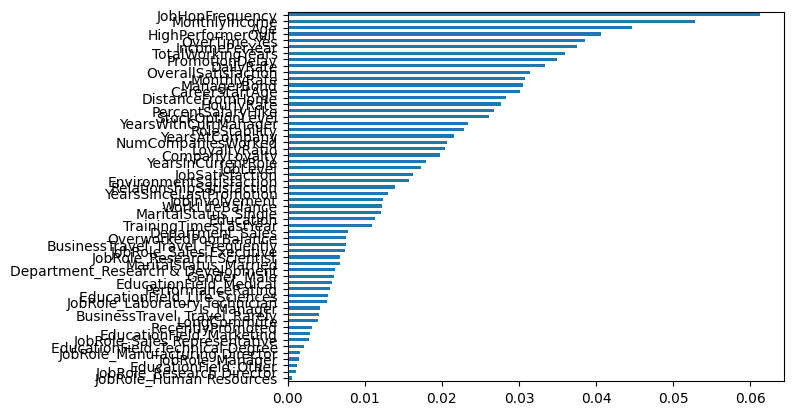

In [31]:
# Best model로 Feature importance 확인
best_model = grid_search.best_estimator_
fi = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
fi
fi.sort_values().plot(kind="barh")

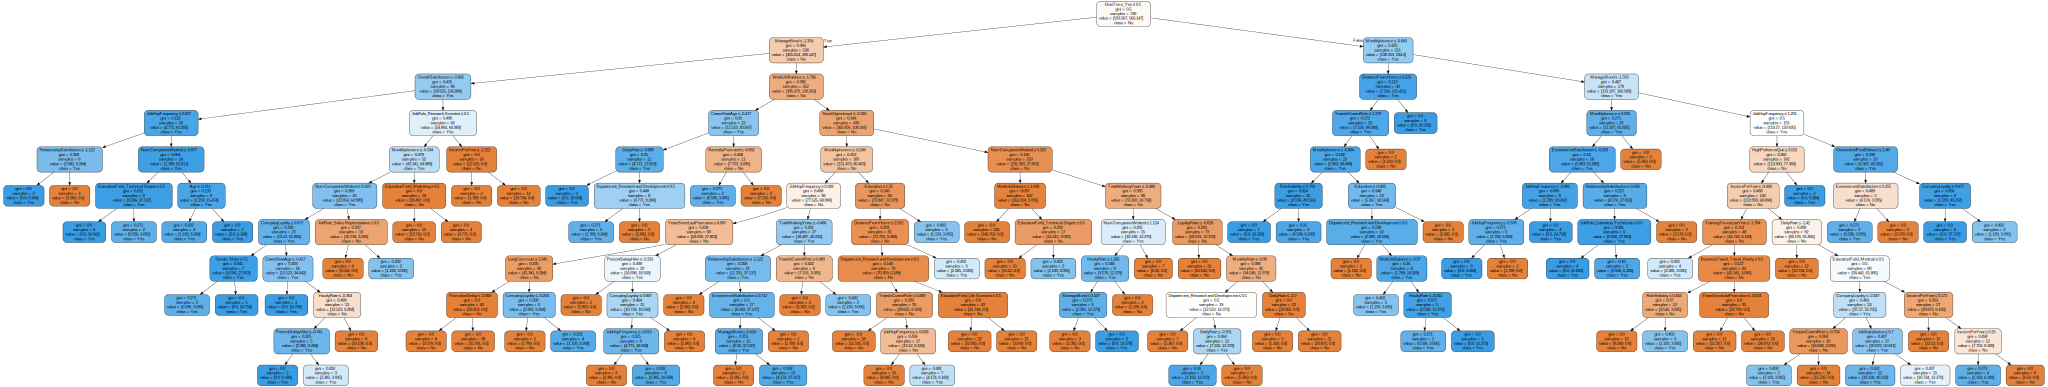

In [33]:
# graphviz 를 이용해 Best Model의 추론 구조 확인
from sklearn.tree import export_graphviz
from graphviz import Source

# 피처 이름에서 '&' 문자를 'and'로 치환하여 DOT 오류 방지
sanitized_features = [col.replace("&", "and") for col in X.columns]

# RandomForest에서 첫 번째 트리 추출
estimator = best_model.estimators_[0]


dot_data = export_graphviz(
    estimator,
    out_file=None,
    feature_names=sanitized_features,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,
    special_characters=True
)


graph = Source(dot_data)
graph
